# Preamble

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.patches as patches
from regions import read_ds9,write_ds9,PixCoord,BoundingBox,CirclePixelRegion
from astropy.io import fits
from astropy.stats import SigmaClip
import palettable.colorbrewer as pc
from cycler import cycler
from scipy.optimize import curve_fit
from astropy.stats import SigmaClip
from collections import OrderedDict
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset




plt.rcParams["axes.prop_cycle"]=cycler('color',pc.qualitative.Set3_12.mpl_colors)
%matplotlib inline

data_path=os.getcwd()+"/0_PATIENT_DATA/"   
mole_df=pd.read_csv(data_path+"/0_MASTER_MOLES.csv",converters={'PHOTO': lambda x: str(x)})




Insert leading zeros by hand

(Warning: takes a while!)

In [2]:
patient="F"
photo="29010"
mole="10"


## BE CAREFUL -- currently just inserting leading zeros by hand to photo names with > 5 characters
def LEADING_ZEROS(row):
    if len(row["PHOTO"]) > 5:
        return (row["PHOTO"]).zfill(8)
    else:
        return row["PHOTO"]


mole_df.loc[:,"PHOTO"]=mole_df.apply(LEADING_ZEROS, axis=1)
mole_df.loc[:,"PHOTO_PATH"]=data_path+"/"+mole_df.PATIENT+"/"+mole_df.PHOTO+"/"+mole_df.PHOTO



# mole_ID="D_29131_POS03_8"
# MOLE=legit_moles.loc[(legit_moles.MOLE_ID==mole_ID)]

legit_moles=mole_df.dropna(subset=["red_SKIN",
                                   "dred_SKIN",
                                   "AMP_red_SKIN",
                                   "green_SKIN",
                                   "dgreen_SKIN",
                                   "AMP_green_SKIN",
                                   "blue_SKIN",
                                   "dblue_SKIN",
                                   "AMP_blue_SKIN",
                                   "red_MOLE",
                                   "dred_MOLE",
                                   "AMP_red_MOLE",
                                   "green_MOLE",
                                   "dgreen_MOLE",
                                   "AMP_green_MOLE",
                                   "blue_MOLE",
                                   "dblue_MOLE",
                                   "AMP_blue_MOLE"])

print(len(legit_moles))

3920


Start by finding how many patients have two or more time periods:

In [5]:
mole_df=pd.read_csv(data_path+"/0_MASTER_MOLES.csv",converters={'PHOTO': lambda x: str(x)})

mole_df.loc[:,"PHOTO"]=mole_df.apply(LEADING_ZEROS, axis=1)
mole_df.loc[:,"PHOTO_PATH"]=data_path+"/"+mole_df.PATIENT+"/"+mole_df.PHOTO+"/"+mole_df.PHOTO



# mole_ID="D_29131_POS03_8"
# MOLE=legit_moles.loc[(legit_moles.MOLE_ID==mole_ID)]

legit_moles=mole_df.dropna(subset=["red_SKIN",
                                   "dred_SKIN",
                                   "AMP_red_SKIN",
                                   "green_SKIN",
                                   "dgreen_SKIN",
                                   "AMP_green_SKIN",
                                   "blue_SKIN",
                                   "dblue_SKIN",
                                   "AMP_blue_SKIN",
                                   "red_MOLE",
                                   "dred_MOLE",
                                   "AMP_red_MOLE",
                                   "green_MOLE",
                                   "dgreen_MOLE",
                                   "AMP_green_MOLE",
                                   "blue_MOLE",
                                   "dblue_MOLE",
                                   "AMP_blue_MOLE"])

print(len(legit_moles))


df = legit_moles.groupby('PATIENT')['OBS_DATE'].nunique()
legit_patients=df[df==2].index.values
legit_patients


3920


array(['D', 'F', 'P', 'R'], dtype=object)

## save which photos correspond to which position
(will use this to only start with the back images)

In [6]:
legit_moles.loc[:,"POSITION"]=[MOLE_ID_VAL.split("_")[2] for MOLE_ID_VAL in legit_moles.MOLE_ID]

## also save approx size as median of red, green and blue mole sizes that are now present in mole_df

legit_moles.loc[:,"APPROX_MOLE_SIZE"]=np.nanmedian(legit_moles[["red_MOLE_SIZE_PIXELS","green_MOLE_SIZE_PIXELS","blue_MOLE_SIZE_PIXELS"]],axis=1)
print(legit_moles.loc[legit_moles.red_MOLE_SIZE_PIXELS.astype(str)=="nan"][["red_MOLE_SIZE_PIXELS","green_MOLE_SIZE_PIXELS","blue_MOLE_SIZE_PIXELS","APPROX_MOLE_SIZE"]])

## APPROX_MOLE_SIZE is the number of pixels
## Use this as a proxy for area, then we can assume the mole is circular, and get an approximate radius

legit_moles.loc[:,"APPROX_MOLE_RADIUS"]=np.sqrt(legit_moles.APPROX_MOLE_SIZE/np.pi)
legit_moles.loc[:,"APPROX_MOLE_RADIUS_red"]=np.sqrt(legit_moles.red_MOLE_SIZE_PIXELS/np.pi)
legit_moles.loc[:,"APPROX_MOLE_RADIUS_green"]=np.sqrt(legit_moles.green_MOLE_SIZE_PIXELS/np.pi)
legit_moles.loc[:,"APPROX_MOLE_RADIUS_blue"]=np.sqrt(legit_moles.blue_MOLE_SIZE_PIXELS/np.pi)


# print(legit_moles[["APPROX_MOLE_SIZE","APPROX_MOLE_RADIUS"]])


/Users/pboorman/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/pboorman/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


      red_MOLE_SIZE_PIXELS  green_MOLE_SIZE_PIXELS  blue_MOLE_SIZE_PIXELS  \
106                    NaN                   102.0                  243.0   
490                    NaN                   346.0                  400.0   
1683                   NaN                     NaN                  376.0   
1738                   NaN                   698.0                  776.0   

      APPROX_MOLE_SIZE  
106              172.5  
490              373.0  
1683             376.0  
1738             737.0  


Two photos for patient P:
['10652' '35764']
MIN_SAMPS VALUE BEING USED 364.0
EPS VALUE BEING USED 16
Estimated number of clusters: 16

MIN_SAMPS VALUE BEING USED 308.0
EPS VALUE BEING USED 16
Estimated number of clusters: 66



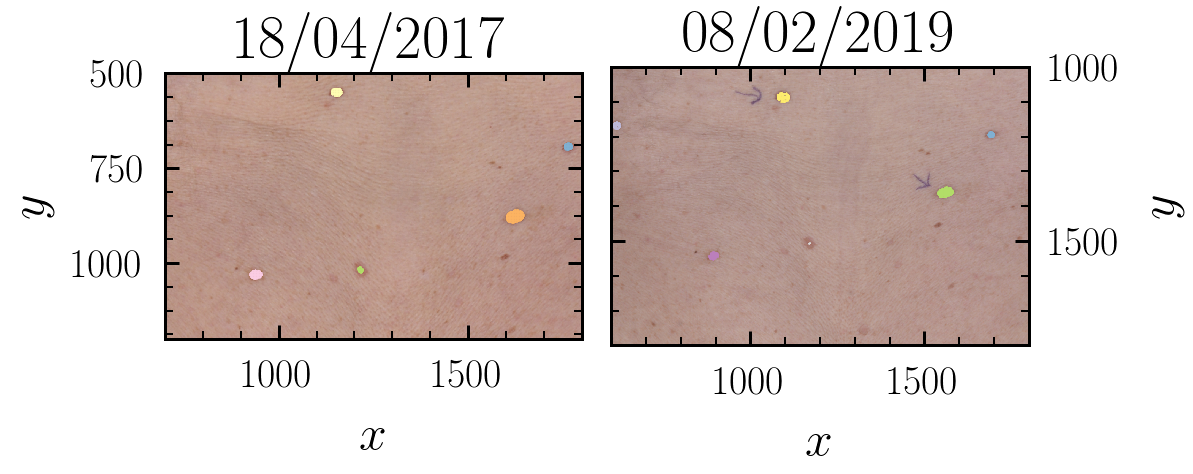

In [12]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler




def PLOT_DBSCAN_MOLES(AX,IM_CLUSTERS,LABELS,BAND,PHOTO,MOLES_DF):
#     IM_CLUSTERS=im4#FILTERED_IM.NEW_CLUSTER_LABEL.values#.reshape(red.shape)
    alt_labels=LABELS
    
    ## to plot mole size distribution from manually extracted moles
#     fig,ax=plt.subplots(figsize=(9,9))
#     M_SIZES=MOLES_DF.loc[(MOLES_DF.PHOTO==PHOTO)][BAND+"_MOLE_SIZE_PIXELS"].values
#     N,B=np.histogram(M_SIZES,bins=np.linspace(np.min(M_SIZES),np.max(M_SIZES),20))
#     BC=(B[0:-1]+B[1:])/2.
#     ax.plot(BC,N,lw=0.,marker="o",markersize=10)
#     plt.show()
    max_mole_size=np.max(MOLES_DF.loc[(MOLES_DF.PHOTO==PHOTO)][BAND+"_MOLE_SIZE_PIXELS"])
    u90=np.quantile(MOLES_DF.loc[(MOLES_DF.PHOTO==PHOTO)][BAND+"_MOLE_SIZE_PIXELS"],0.90)
    u68=np.quantile(MOLES_DF.loc[(MOLES_DF.PHOTO==PHOTO)][BAND+"_MOLE_SIZE_PIXELS"],0.68)
    u50=np.quantile(MOLES_DF.loc[(MOLES_DF.PHOTO==PHOTO)][BAND+"_MOLE_SIZE_PIXELS"],0.50)
    u84=np.quantile(MOLES_DF.loc[(MOLES_DF.PHOTO==PHOTO)][BAND+"_MOLE_SIZE_PIXELS"],0.84)
    u16=np.quantile(MOLES_DF.loc[(MOLES_DF.PHOTO==PHOTO)][BAND+"_MOLE_SIZE_PIXELS"],0.16)
    
    ## here we reject any clusters that are bigger than the largest manually extracted mole
    ## effectively removes "clusters" that are just shadows, etc.
#     for i,label in enumerate(np.unique(labels)):
#         if len(labels[labels==label])>max_mole_size:
#             alt_labels[alt_labels==label]=-1


    ## here we include only the N <CRITERIA> moles
#     print("max_mole_size,u90,u68")
#     print(max_mole_size,u90,u68)
#     for j,label in enumerate(np.unique(labels)):
#         if (len(labels[labels==label])>2000)or(len(labels[labels==label])<500):#len(labels[labels==label])<u16)or(len(labels[labels==label])>u84:
#             alt_labels[alt_labels==label]=-1
        
    ## now we find the approximate coordinate of the center of each of the remaining clusters
    for k,label in enumerate(np.unique(labels)):
        CLUSTER_LOCS=IM_CLUSTERS[labels==label]
        CLUSTER_LOC=np.array([np.median(CLUSTER_LOCS[:,0]),np.median(CLUSTER_LOCS[:,1])])
#         AX.scatter(CLUSTER_LOC[1],CLUSTER_LOC[0],s=100.)

#     print("Tried to identify actual moles in DBSCAN findings...")        

    # Black removed and is used for noise instead.
    unique_labels = set(alt_labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels),dtype=int))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'
            continue

        class_member_mask = (alt_labels == k)
        col2=int(np.random.uniform(0,len(colors)))
        xy = IM_CLUSTERS[(class_member_mask) & (core_samples_mask)]
        AX.plot(xy[:, 1],xy[:, 0], ',', markersize=0.5,alpha=0.5)#markerfacecolor=colors[col2], markeredgecolor=colors[col2]

#     for i,MOLE in MOLES_DF.loc[(MOLES_DF.PHOTO==PHOTO)].iterrows():
#         REG=CirclePixelRegion(PixCoord(x=float(MOLE.REG_XCENTER_PIXELS), y=float(MOLE.REG_YCENTER_PIXELS)), radius=float(MOLE.FIT_REG_RADIUS_PIXELS))
#         artist=REG.as_artist()
#         AX.add_artist(artist)















## Only considering patient F, as the most analysis has been done for this one so far!
legit_patients=["P"]
new_legit_moles=legit_moles[(legit_moles.PATIENT.isin(legit_patients))&(legit_moles.POSITION=="POS02")]
legit_photos=new_legit_moles.sort_values(['PATIENT','OBS_DATE'],ascending=False).groupby('PATIENT')['PHOTO'].unique()
        
for i,PATIENT in enumerate(legit_patients):
    print("Two photos for patient %(PATIENT)s:" %locals())
    print(legit_photos[i])
    fig=plt.figure(figsize=(12,8))
    gs=gridspec.GridSpec(1,2)
    gs.update(left=0.,right=1.,bottom=0.,top=0.98,wspace=0.07,hspace=0.025)
    
    ## first temporal photo
    ax1=fig.add_subplot(gs[0,0])
    
    ## second temporal photo
    ax2=fig.add_subplot(gs[0,1])

    for j,photo in enumerate(legit_photos[i]):
        PHOTO_PATH=data_path+"/"+PATIENT+"/"+photo+"/"+photo

        image=mpimg.imread(str(PHOTO_PATH)+"ORIGINAL.jpg")[::-1]
        
        ## this code is for turning photo into pandas dataframe
#         ## loads pixel_df for all bands
#         red=fits.open(PHOTO_PATH+"red.fits")[0].data
#         green=fits.open(PHOTO_PATH+"green.fits")[0].data
#         blue=fits.open(PHOTO_PATH+"blue.fits")[0].data

#         pixel_df=pd.DataFrame(data={"red_raw":np.array(red).byteswap().newbyteorder().flatten("C"),
#                                     "green_raw":np.array(green).byteswap().newbyteorder().flatten("C"),
#                                     "blue_raw":np.array(blue).byteswap().newbyteorder().flatten("C")})

#         ## this enables creation of image from dataframe
#         # image=pixel_df.red_raw.reshape(red.shape)

#         pixel_df.loc[:,"RG"]=pixel_df.red_raw/pixel_df.green_raw
#         pixel_df.loc[:,"RB"]=pixel_df.red_raw/pixel_df.blue_raw
#         pixel_df.loc[:,"GB"]=pixel_df.green_raw/pixel_df.blue_raw

        
        for k,band in enumerate(["blue"]):#,"green","red"]):
            avskin=np.mean(legit_moles.loc[(legit_moles.PHOTO==photo)][band+"_SKIN"])
            d_avskin=np.sqrt((legit_moles.loc[(legit_moles.PHOTO==photo)]["d"+band+"_SKIN"]**2).sum())
            avmole=np.mean(legit_moles.loc[(legit_moles.PHOTO==photo)][band+"_MOLE"])
            d_avmole=np.sqrt((legit_moles.loc[(legit_moles.PHOTO==photo)]["d"+band+"_MOLE"]**2).sum())
            
            im=fits.open(str(PHOTO_PATH)+band+".fits")[0].data
            ## im2 contains everything that *isn't* skin and fainter than the maximum brightness of mole
            ## this appears to work better at the moment (skin is better defined)
            im2=np.ma.masked_where(((im>avskin-d_avskin) & (im<avskin+d_avskin)),im)
#             im2=im2[450:1200,800:1400]
            im2b=np.ma.masked_where((im2>avmole+d_avmole),im2)
            
            ## im3 contains everything that *should* be a mole
            ## (not currently used)
#             im3=np.ma.masked_where(~((im>avmole-d_avmole) & (im<avmole+d_avmole)),im) 
            db_input=np.argwhere(im2b>0.)
#             ax1.imshow(im2[::-1])
#             ax2.imshow(im2b[::-1])
            APPROX_MIN_SAMPS=np.min(legit_moles.loc[(legit_moles.PHOTO==photo)][band+"_MOLE_SIZE_PIXELS"])
            print("MIN_SAMPS VALUE BEING USED",APPROX_MIN_SAMPS)
            APPROX_EPS=16
            print("EPS VALUE BEING USED",APPROX_EPS)
            
            ## use this code to iteratively increase the eps value
            ## useful for finding an optimum
#             while APPROX_EPS<17:#np.max(legit_moles.loc[(legit_moles.PHOTO==photo)][band+"_MOLE_SIZE_PIXELS"]):

                #np.max(legit_moles.loc[(legit_moles.PHOTO==photo)]["APPROX_MOLE_RADIUS_"+band])
#                 print("APPROX_EPS",APPROX_EPS)

#                 print(APPROX_EPS,APPROX_MIN_SAMPS)
#                 pixel_df_subset=pixel_df[band+"_raw"]
    #             pixel_df=pixel_df.fillna(0.)
#                 pixel_df_temp=StandardScaler().fit_transform(im4)

            db=DBSCAN(eps=APPROX_EPS,min_samples=APPROX_MIN_SAMPS).fit(db_input)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

            print('Estimated number of clusters: %d' % n_clusters_)
            print()
            APPROX_EPS+=1
            
            
            
        

        if j==0:
            AX=ax1
            AX.set_ylim(500,1200)
            AX.set_xlim(700,1800)
        else:
            AX=ax2
            AX.yaxis.tick_right()
            AX.yaxis.set_label_position("right")
            AX.yaxis.set_ticks_position('both')
            AX.set_ylim(1000,1800)
            AX.set_xlim(600,1800)

        AX.imshow(image)
        PLOT_DBSCAN_MOLES(AX,db_input,labels,band,photo,legit_moles)
        
        OBS_DATE_TITLE=legit_moles.loc[legit_moles.PHOTO==photo].OBS_DATE.values[0]
        AX.set_title(OBS_DATE_TITLE,y=1.02,fontsize=60.)
        AX.imshow(image)
        AX.set_ylim(AX.get_ylim()[::-1])
#         AX.set_ylim(400,1800)
#         AX.set_xlim(400,1800)
        AX.set_xlabel(r"$x$")
        AX.set_ylabel(r"$y$")
        
    fig.savefig("./test_DBSCAN3.png")
 

In [23]:
from PIL import Image 


imFilename = '/home/mj1e16/moleGazer/Photos/F/29018.jpg'
refFilename =  '/home/mj1e16/moleGazer/Photos/F/79948.jpg'

def crop(imName,prefix):
    im = Image.open(imName)
    width,height = im.size
    print(width,height)
    bottom = 1
    top = height - 100
    left = 1
    right = width -1
    print(bottom,top,left,right)
    #left, top, right, bottom
    im1 = im.crop((50,100,100,50)) 
    im1.show()
    im1.save(prefix+'crop.jpeg')
    
crop(imFilename,'Align')
crop(refFilename,'Ref')

1190 3800
1 3700 1 1189


SystemError: tile cannot extend outside image

# Image alignment
This uses cv2, and so may require being run in Python 2.7

In [9]:
from __future__ import print_function
import cv2
import numpy as np

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15


imFilename = '/home/mj1e16/moleGazer/Photos/F/29018.jpg'
refFilename =  '/home/mj1e16/moleGazer/Photos/F/79948.jpg'

def alignImages(im1, im2):
 
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h


# Read reference image
#refFilename = "/Users/pboorman/Dropbox/1_work/2_inprep/1e_molegazer/0_PATIENT_DATA/F/29010/29010"+"ORIGINAL.jpg"
print("Reading reference image : ", refFilename)
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

# Read image to be aligned
#imFilename = "/Users/pboorman/Dropbox/1_work/2_inprep/1e_molegazer/0_PATIENT_DATA/F/79941/79941"+"ORIGINAL.jpg"
print("Reading image to align : ", imFilename);  
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

print("Aligning images ...")
# Registered image will be resotred in imReg. 
# The estimated homography will be stored in h. 
imReg, h = alignImages(im, imReference)

# Write aligned image to disk. 
outFilename = "aligned.jpg"
print("Saving aligned image : ", outFilename); 
cv2.imwrite(outFilename, imReg)

# Print estimated homography
print("Estimated homography : \n",  h)

Reading reference image :  /home/mj1e16/moleGazer/Photos/F/79948.jpg
Reading image to align :  /home/mj1e16/moleGazer/Photos/F/29018.jpg
Aligning images ...
Saving aligned image :  aligned.jpg
Estimated homography : 
 [[  7.99600011e-01  -2.45702881e-01   9.23040537e+02]
 [ -6.01956605e-02   3.05475712e-01   8.21190045e+02]
 [ -1.62020459e-05  -1.25840204e-04   1.00000000e+00]]


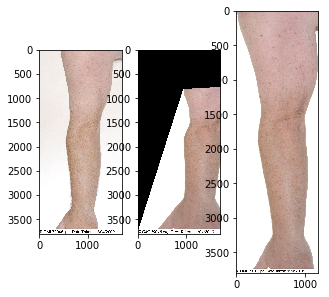

In [10]:
import matplotlib.pyplot as pl
import matplotlib.image as mpimg

img1=mpimg.imread(refFilename)
img2=mpimg.imread('aligned.jpg')
img3=mpimg.imread(imFilename)

fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(5,10))
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
plt.show()

### This cell was an attempt to use pandas dataframes. Unfortunately does not work yet!

In [ ]:
# MASK=(pixel_df.blue_raw.astype(float)>avskin-d_avskin) & (pixel_df.blue_raw.astype(float)<avskin+d_avskin) & (pixel_df.blue_raw.astype(float)>avmole+d_avmole)
# print(len(labels))
# print(len(MASK))
# pixel_df.loc[:,"DBSCAN_CLUSTER"]=0.
# pixel_df.loc[~MASK,"DBSCAN_CLUSTER"]=labels
# print(pixel_df.DBSCAN_CLUSTER.nunique())
# image=pixel_df.blue_raw.values.reshape(blue.shape)
# MOLES=pixel_df.DBSCAN_CLUSTER.values.reshape(blue.shape)

# max_mole_size=(np.max(legit_moles.loc[(legit_moles.PHOTO==photo)][band+"_MOLE_SIZE_PIXELS"]))
# print(pixel_df.groupby(pixel_df.DBSCAN_CLUSTER).DBSCAN_CLUSTER.value_counts().loc[lambda x: x<max_mole_size].values)

# print(len(pixel_df.DBSCAN_CLUSTER.value_counts()))
# # print(pixel_df.DBSCAN_CLUSTER.value_counts().index.values)

# new_clusters=np.array([])
# for i,CLUSTER in enumerate(pixel_df.DBSCAN_CLUSTER.value_counts().index.values):
#     CLUSTER_SIZE=len(pixel_df.loc[pixel_df.DBSCAN_CLUSTER==CLUSTER])
# #     print(CLUSTER_SIZE,max_mole_size)
#     if CLUSTER_SIZE<max_mole_size:
# #         pixel_df.loc[pixel_df.DBSCAN_CLUSTER==CLUSTER]["NEW_CLUSTER_LABEL"]=-1.
#         new_clusters=np.append(new_clusters,float(CLUSTER))

    
# pixel_df.loc[:,"NEW_CLUSTER_LABEL"]=pixel_df.DBSCAN_CLUSTER
    
# pixel_df.loc[~pixel_df.DBSCAN_CLUSTER.isin(new_clusters),"NEW_CLUSTER_LABEL"]=-1

# print(pixel_df.NEW_CLUSTER_LABEL.value_counts())

# # fig,ax=plt.subplots(figsize=(9,12))
# # ax.imshow(image)
# # ax.imshow(MOLES)

## Plot the clusters identified by DBSCAN on the patient image.
(Needs the DBSCAN algorithm to have been run, preferably in the above cell)

(2338756,)
Tried to identify actual moles in DBSCAN findings...


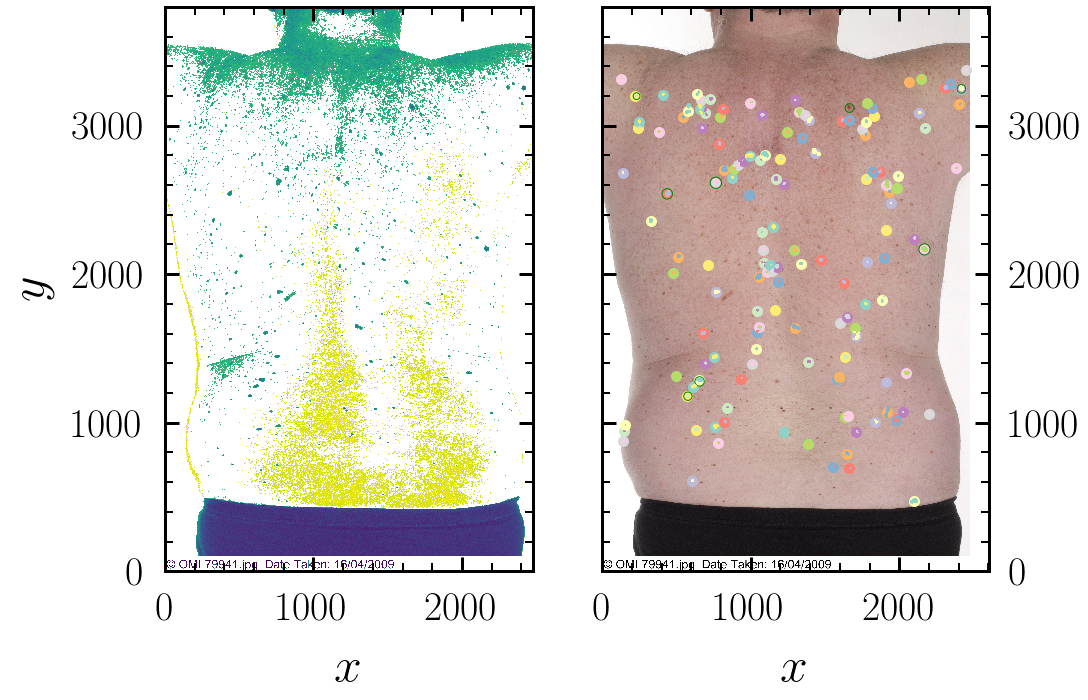

In [105]:
fig=plt.figure(figsize=(12,8))
gs=gridspec.GridSpec(1,2)
gs.update(left=0.,right=1.,bottom=0.,top=0.98,wspace=0.07,hspace=0.025)

## first temporal photo
ax1=fig.add_subplot(gs[0,0])

## second temporal photo
ax2=fig.add_subplot(gs[0,1])

ax1.imshow(im2b)
ax2.imshow(image)
       
# FILTERED_IM=pixel_df.loc[(pixel_df.red_raw.astype(float)<avskin+d_avskin)&(pixel_df.red_raw.astype(float)>avskin-d_avskin)]
# IM_CLUSTERS=pixel_df.NEW_CLUSTER_LABEL.values.reshape(red.shape)
print(labels.shape)
IM_CLUSTERS=im4#FILTERED_IM.NEW_CLUSTER_LABEL.values#.reshape(red.shape)
alt_labels=labels
max_mole_size=np.max(legit_moles.loc[(legit_moles.PHOTO==photo)][band+"_MOLE_SIZE_PIXELS"])
for i,label in enumerate(np.unique(labels)):
    if len(labels[labels==label])>max_mole_size:
        alt_labels[alt_labels==label]=-1


for j,label in enumerate(np.unique(labels)):
    CLUSTER_LOCS=np.argwhere(im2b>0.)[labels==label]
    CLUSTER_LOC=np.array([np.median(CLUSTER_LOCS[:,0]),np.median(CLUSTER_LOCS[:,1])])
    ax2.scatter(CLUSTER_LOC[1],CLUSTER_LOC[0],s=100.)

print("Tried to identify actual moles in DBSCAN findings...")        

# Black removed and is used for noise instead.
unique_labels = set(alt_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels),dtype=int))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
        continue

    class_member_mask = (alt_labels == k)
    col2=int(np.random.uniform(0,len(colors)))
    xy = IM_CLUSTERS[(class_member_mask) & (core_samples_mask)]
#     ax1.plot(xy[:, 1],xy[:, 0], ',', markersize=0.5,alpha=0.5)#markerfacecolor=colors[col2], markeredgecolor=colors[col2]
    ax2.plot(xy[:, 1],xy[:, 0], ',', markersize=0.5,alpha=0.5)#markerfacecolor=colors[col2], markeredgecolor=colors[col2]
    #xy = im3[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=0.1)

# IM_CLUSTERS2=pixel_df.NEW_CLUSTER_LABEL.values.reshape(red.shape)
# IM_CLUSTERS2=np.ma.masked_less_equal(IM_CLUSTERS2,0.).astype(bool)
# ax2.plot(IM_CLUSTERS2)  
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.set_ylim(ax2.get_ylim()[::-1])


ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position('both')


ax1.set_xlabel(r"$x$")
ax2.set_xlabel(r"$x$")
ax1.set_ylabel(r"$y$")



for i,MOLE in legit_moles.loc[(legit_moles.PHOTO==photo)].iterrows():
    REG=CirclePixelRegion(PixCoord(x=float(MOLE.REG_XCENTER_PIXELS), y=float(MOLE.REG_YCENTER_PIXELS)), radius=float(MOLE.FIT_REG_RADIUS_PIXELS))
    artist=REG.as_artist()
    ax2.add_artist(artist)


        
plt.savefig('/Users/pboorman/Desktop/TestDBSCAN2.png', dpi=300)